In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
df = pd.read_csv('/content/drive/Shared drives/SIH2020/Dataset/atomdata/datawithoutgroup.csv')
df.head()

,Unnamed: 0,RF,UTC_Start,UTC_Stop,Latitude,Longitude,Altitude (m masl GPS),Speed,Acceleration
0,0,1.0,0.0,10.0,34.630960,-118.107350,799.533333,0.000665,0.000033
1,1,1.0,10.0,20.0,34.630694,-118.113999,842.990000,0.000994,0.000003
2,2,1.0,20.0,30.0,34.630241,-118.123933,918.600000,0.001027,0.000004
3,3,1.0,30.0,40.0,34.629899,-118.134193,980.130000,0.001065,-0.000004
4,4,1.0,40.0,50.0,34.630087,-118.144843,1037.710000,0.001029,0.000003


In [3]:
df.columns
df.rename(columns={'Altitude (m masl GPS)':'Altitude'},inplace=True)
df.head()

,Unnamed: 0,RF,UTC_Start,UTC_Stop,Latitude,Longitude,Altitude,Speed,Acceleration
0,0,1.0,0.0,10.0,34.630960,-118.107350,799.533333,0.000665,0.000033
1,1,1.0,10.0,20.0,34.630694,-118.113999,842.990000,0.000994,0.000003
2,2,1.0,20.0,30.0,34.630241,-118.123933,918.600000,0.001027,0.000004
3,3,1.0,30.0,40.0,34.629899,-118.134193,980.130000,0.001065,-0.000004
4,4,1.0,40.0,50.0,34.630087,-118.144843,1037.710000,0.001029,0.000003


In [4]:
data = df[['Latitude','Longitude','Altitude']]
data.head()

,Latitude,Longitude,Altitude
0,34.630960,-118.107350,799.533333
1,34.630694,-118.113999,842.990000
2,34.630241,-118.123933,918.600000
3,34.629899,-118.134193,980.130000
4,34.630087,-118.144843,1037.710000


In [5]:

new = data.shift(-1,axis=0)
new.head()

,Latitude,Longitude,Altitude
0,34.630694,-118.113999,842.99
1,34.630241,-118.123933,918.60
2,34.629899,-118.134193,980.13
3,34.630087,-118.144843,1037.71
4,34.631843,-118.154980,1109.23


In [6]:
final = pd.concat([data,new],axis=1)
final.head()

,Latitude,Longitude,Altitude,Latitude,Longitude,Altitude
0,34.630960,-118.107350,799.533333,34.630694,-118.113999,842.99
1,34.630694,-118.113999,842.990000,34.630241,-118.123933,918.60
2,34.630241,-118.123933,918.600000,34.629899,-118.134193,980.13
3,34.629899,-118.134193,980.130000,34.630087,-118.144843,1037.71
4,34.630087,-118.144843,1037.710000,34.631843,-118.154980,1109.23


In [7]:
print(len(final))
final.dropna(inplace=True)
print(len(final))

166400
166399


In [8]:
values = final.values
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)
X = values[:,:3]
Y = values[:,3:]

In [9]:
X_train, X_test,Y_train,Y_test = train_test_split(X,Y,test_size=1000,shuffle=False)

In [10]:
print(X_train.shape,X_test.shape)

(165399, 3) (1000, 3)


In [11]:
X_train = np.reshape(X_train,(165399,1,3))
X_test = np.reshape(X_test,(1000,1,3))


In [12]:
def create_model():
  model = Sequential()
  model.add(LSTM(15, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dense(3))
  return model


In [13]:
def train_model(filepath):
  model = create_model()
  model.compile(loss='mae', optimizer='adam')
  # fit network
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
  history = model.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=2, shuffle=False,callbacks=[checkpoint])
  return history

In [14]:
filepath = '/content/drive/Shared drives/SIH2020/Akash_prediction/lstm_1_timestep_noshuffle.hdf5'
history = train_model(filepath)

Train on 165399 samples, validate on 1000 samples
Epoch 1/30
 - 8s - loss: 0.1050 - val_loss: 0.0331

Epoch 00001: val_loss improved from inf to 0.03312, saving model to /content/drive/Shared drives/SIH2020/Akash_prediction/lstm_1_timestep_noshuffle.hdf5
Epoch 2/30
 - 8s - loss: 0.0158 - val_loss: 0.0316

Epoch 00002: val_loss improved from 0.03312 to 0.03157, saving model to /content/drive/Shared drives/SIH2020/Akash_prediction/lstm_1_timestep_noshuffle.hdf5
Epoch 3/30
 - 8s - loss: 0.0106 - val_loss: 0.0232

Epoch 00003: val_loss improved from 0.03157 to 0.02319, saving model to /content/drive/Shared drives/SIH2020/Akash_prediction/lstm_1_timestep_noshuffle.hdf5
Epoch 4/30
 - 8s - loss: 0.0079 - val_loss: 0.0173

Epoch 00004: val_loss improved from 0.02319 to 0.01734, saving model to /content/drive/Shared drives/SIH2020/Akash_prediction/lstm_1_timestep_noshuffle.hdf5
Epoch 5/30
 - 8s - loss: 0.0065 - val_loss: 0.0199

Epoch 00005: val_loss did not improve from 0.01734
Epoch 6/30
 - 8

In [15]:
model = create_model()
model.load_weights(filepath)

yhat = model.predict(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[2]))

yhat = np.concatenate((yhat,X_test),axis=1)
inv_yhat = scaler.inverse_transform(yhat)

Y_test = np.concatenate((Y_test,X_test),axis=1)
inv_y = scaler.inverse_transform(Y_test)

d1 = pd.DataFrame(inv_yhat)
d2 = pd.DataFrame(inv_y)

inv_yhat = d1.iloc[:,:3]
inv_y = d2.iloc[:,:3]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
#rmse = math.sqrt(mean_squared_error(yhat,Y_test))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 36.822


In [16]:
yhat

array([[0.72559708, 0.16494507, 0.03912583, 0.72545516, 0.16854241,
        0.0342576 ],
       [0.7255429 , 0.16496995, 0.03936603, 0.72540141, 0.1685668 ,
        0.03451319],
       [0.72548807, 0.16499394, 0.03909058, 0.72534712, 0.16859202,
        0.03422282],
       ...,
       [0.50285125, 0.50213957, 0.00444021, 0.50956854, 0.49999927,
        0.        ],
       [0.50285125, 0.50213957, 0.00444021, 0.50956854, 0.49999927,
        0.        ],
       [0.50285125, 0.50213957, 0.00444021, 0.50956854, 0.49999927,
        0.        ]])

In [17]:
inv_yhat.head()

,0,1,2
0,36.534129,-120.619335,517.419880
1,36.524967,-120.610376,520.596496
2,36.515693,-120.601739,516.953782
3,36.506227,-120.594438,501.992699
4,36.497024,-120.584874,508.763995


In [18]:
d1.iloc[:,3:].head()

,3,4,5
0,36.510128,-119.324291,453.04
1,36.501037,-119.315511,456.42
2,36.491857,-119.306432,452.58
3,36.482541,-119.297616,436.75
4,36.473387,-119.288560,443.94


In [19]:
d2.iloc[:,3:].head()

,3,4,5
0,36.510128,-119.324291,453.04
1,36.501037,-119.315511,456.42
2,36.491857,-119.306432,452.58
3,36.482541,-119.297616,436.75
4,36.473387,-119.288560,443.94


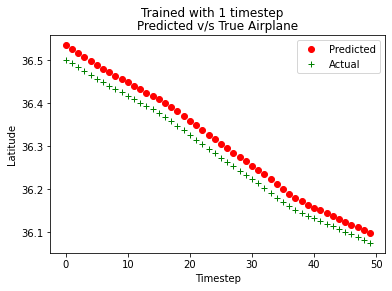

In [30]:
t = np.arange(50)
x_pred = d1.iloc[:50,0]
x_true = d2.iloc[:50,0]
plt.plot(t,x_pred,'ro', label ='Predicted') 
plt.plot(t,x_true,'g+', label ='Actual')
plt.legend()
plt.xlabel('Timestep')
plt.ylabel('Latitude')
plt.title('Predicted v/s True Airplane')
plt.suptitle('Trained with 1 timestep')
plt.savefig('/content/drive/Shared drives/SIH2020/Akash_prediction/lstm_1_lat_time.png')
plt.show()

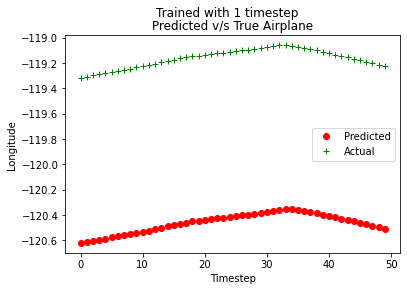

In [31]:
t = np.arange(50)
x_pred = d1.iloc[:50,1]
x_true = d2.iloc[:50,1]
plt.plot(t,x_pred,'ro', label ='Predicted') 
plt.plot(t,x_true,'g+', label ='Actual')
plt.legend()
plt.xlabel('Timestep')
plt.ylabel('Longitude')
plt.title('Predicted v/s True Airplane')
plt.suptitle('Trained with 1 timestep')
plt.savefig('/content/drive/Shared drives/SIH2020/Akash_prediction/lstm_1_lon_time.png')
plt.show()

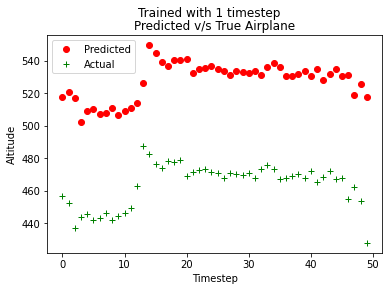

In [32]:
t = np.arange(50)
x_pred = d1.iloc[:50,2]
x_true = d2.iloc[:50,2]
plt.plot(t,x_pred,'ro', label ='Predicted') 
plt.plot(t,x_true,'g+', label ='Actual')
plt.legend()
plt.xlabel('Timestep')
plt.ylabel('Altitude')
plt.title('Predicted v/s True Airplane')
plt.suptitle('Trained with 1 timestep')
plt.savefig('/content/drive/Shared drives/SIH2020/Akash_prediction/lstm_1_alt_time.png')
plt.show()

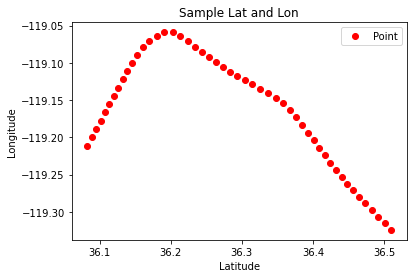

In [23]:
lat = d1.iloc[:50,3]
lon = d1.iloc[:50,4]
plt.plot(lat,lon,'ro', label ='Point') 

plt.legend()
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Sample Lat and Lon')
#plt.suptitle('Trained with 1 timestep')
#plt.savefig('/content/drive/Shared drives/SIH2020/Akash_prediction/lstm_1_lat_lon.png')
plt.show()

(3,)


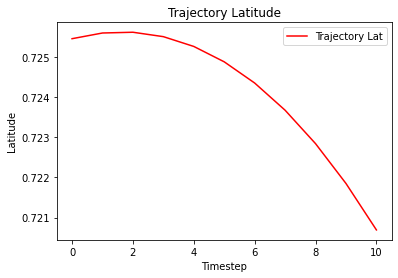

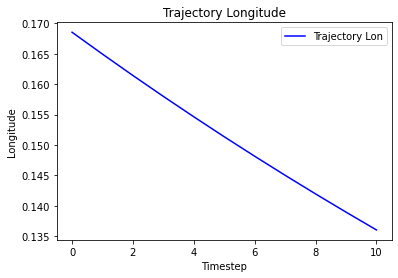

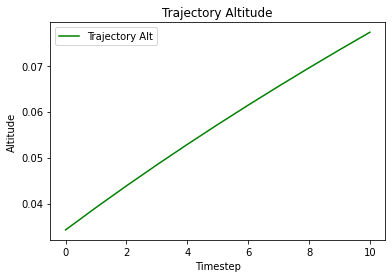

In [24]:
#Trajectory Test
sample = X_test[0]
print(sample.shape)
result = [sample]
sample = np.reshape(X_test[0],(1,1,3))

for i in range(10):
  sample = model.predict(sample)
  result.append(np.reshape(sample,(3,)))
  sample = np.reshape(sample,(1,1,3))
  
f = pd.DataFrame(np.array(result))
t = np.arange(11)
plt.plot(t,f[0],'r-', label ='Trajectory Lat') 
plt.legend()
plt.xlabel('Timestep')
plt.ylabel('Latitude')
plt.title('Trajectory Latitude')
#plt.savefig('/content/drive/Shared drives/SIH2020/Akash_prediction/lstm_1_traj_time.png')
plt.show()



plt.plot(t,f[1],'b-', label ='Trajectory Lon') 
#plt.plot(t,f[2],'g-', label ='Trajectory Alt') 
plt.legend()
plt.xlabel('Timestep')
plt.ylabel('Longitude')
plt.title('Trajectory Longitude')
#plt.savefig('/content/drive/Shared drives/SIH2020/Akash_prediction/lstm_1_traj_lon.png')
plt.show()



plt.plot(t,f[2],'g-', label ='Trajectory Alt') 
plt.legend()
plt.xlabel('Timestep')
plt.ylabel('Altitude')
plt.title('Trajectory Altitude')
#plt.savefig('/content/drive/Shared drives/SIH2020/Akash_prediction/lstm_1_traj_alt.png')
plt.show()







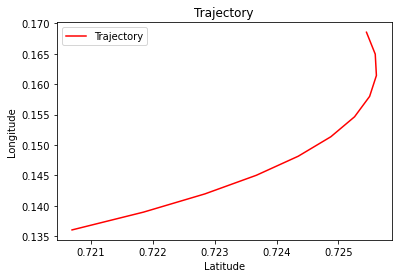

In [25]:

plt.plot(f[0],f[1],'r-', label ='Trajectory') 
plt.legend()
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Trajectory')
#plt.savefig('/content/drive/Shared drives/SIH2020/Akash_prediction/lstm_1_traj_lat_lon.png')
plt.show()


(3,)
(1000, 3)
(11, 3)
(11, 3)


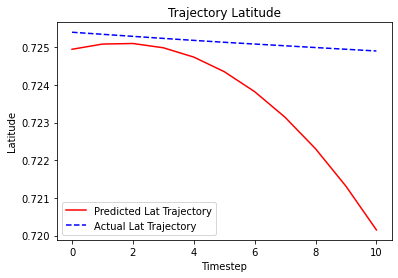

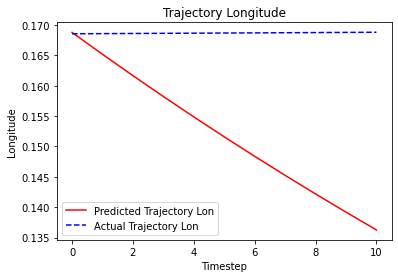

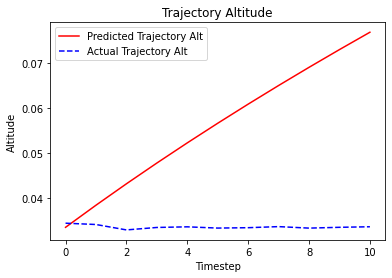

In [26]:
#for trajectory comparison
X_train, X_test,Y_train,Y_test = train_test_split(X,Y,test_size=1000,shuffle=False)
X_train = np.reshape(X_train,(165399,1,3))
X_test = np.reshape(X_test,(1000,1,3))

model = create_model()
filepath = '/content/drive/Shared drives/SIH2020/Akash_prediction/lstm_1_timestep_noshuffle.hdf5'
model.load_weights(filepath)

X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[2]))
#Trajectory Test
sample = X_test[10]
print(sample.shape)
result = [sample]
sample = np.reshape(X_test[10],(1,1,3))

for i in range(10):
  sample = model.predict(sample)
  result.append(np.reshape(sample,(3,)))
  sample = np.reshape(sample,(1,1,3))


print(Y_test.shape)
y = pd.DataFrame(X_test)
z = pd.DataFrame(Y_test[:11,:])
print(z.shape)
f = pd.DataFrame(np.array(result))
print(f.shape)
t = np.arange(11)

'''
f = pd.concat([f,y],axis=1)
f = scaler.inverse_transform(f.to_numpy())
f = pd.DataFrame(f)

z = pd.concat([z,y],axis=1)
z = scaler.inverse_transform(z.to_numpy())
z = pd.DataFrame(z)'''

plt.plot(t,f[0],'r-', label ='Predicted Lat Trajectory') 
plt.plot(t,z[0],'b--',label='Actual Lat Trajectory')
plt.legend()
plt.xlabel('Timestep')
plt.ylabel('Latitude')
plt.title('Trajectory Latitude')
#plt.savefig('/content/drive/Shared drives/SIH2020/Akash_prediction/lstm_1_traj_lat_vs_time.png')
plt.show()



plt.plot(t,f[1],'r-', label ='Predicted Trajectory Lon') 
plt.plot(t,z[1],'b--',label='Actual Trajectory Lon') 
plt.legend()
plt.xlabel('Timestep')
plt.ylabel('Longitude')
plt.title('Trajectory Longitude')
#plt.savefig('/content/drive/Shared drives/SIH2020/Akash_prediction/lstm_1_traj_lon_vs_time.png')
plt.show()



plt.plot(t,f[2],'r-', label ='Predicted Trajectory Alt') 
plt.plot(t,z[2],'b--',label='Actual Trajectory Alt') 
plt.legend()
plt.xlabel('Timestep')
plt.ylabel('Altitude')
plt.title('Trajectory Altitude')
#plt.savefig('/content/drive/Shared drives/SIH2020/Akash_prediction/lstm_1_traj_alt_vs_time.png')
plt.show()







In [27]:
f.head(10)

,0,1,2
0,0.724949,0.168793,0.033602
1,0.725087,0.165190,0.038495
2,0.725102,0.161670,0.043233
3,0.724989,0.158232,0.047830
4,0.724741,0.154872,0.052295
5,0.724354,0.151589,0.056638
6,0.723823,0.148381,0.060868
7,0.723141,0.145245,0.064992
8,0.722305,0.142179,0.069016
9,0.721310,0.139181,0.072945


In [28]:
z.head(10)

,0,1,2
0,0.725401,0.168567,0.034513
1,0.725347,0.168592,0.034223
2,0.725292,0.168617,0.033026
3,0.725238,0.168642,0.033569
4,0.725185,0.168665,0.033710
5,0.725135,0.168690,0.033433
6,0.725088,0.168714,0.033517
7,0.725042,0.168740,0.033756
8,0.724995,0.168766,0.033424
9,0.724949,0.168793,0.033602


(1000, 3)


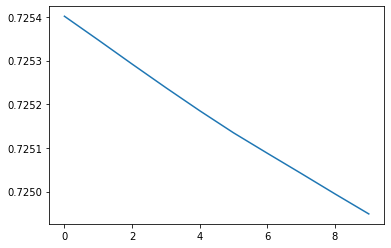

(10, 3)

In [29]:
print(Y_test.shape)
g = pd.DataFrame(Y_test)
z = g.iloc[:10,0]
t = np.arange(10)
plt.plot(t,z)
plt.show()
X_test[:10].shape